[![alt text](https://avatars1.githubusercontent.com/u/59831504?s=400&v=4 "MtheEPIC User Icon")](https://github.com/MtheEPIC/KaggleProj)

# Import libs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.axes_style("whitegrid")

import scipy.integrate as integrate

from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler, binarize, label_binarize
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, plot_roc_curve, confusion_matrix, classification_report, precision_recall_curve, average_precision_score  
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, cross_val_predict, cross_validate

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

# Const And Global Vars

In [97]:
CORES = 3
CV_SPLIT = 10
model_dict = {}
CLASS_NAMES = {0: 'shirt', 1: 'trousers', 2: 'pullover', 3: 'dress', 4: 'coat', 5: 'sandals', 6: 'shirt', 7: 'sneaker', 8: 'bag', 9: 'ankle boots'}

# Declare funcs

In [3]:
def paint():
    tmp = train_df.groupby('label').sum()
    train_data = np.array(tmp, dtype='float32')

    first_image = train_data[0]

    first_image = np.array(first_image, dtype='uint8')
    pixels = first_image.reshape((28, 28))
    import numpy as np; np.random.seed(0)

    import seaborn as sns; sns.set()

    # uniform_data = np.random.rand(10, 12)
    uniform_data = pixels#//500
    ax = sns.heatmap(uniform_data)

    uniform_data.max()

In [4]:
def evaluate(true, pred, plot=False):
#     model_accuracy = roc_auc_score(true, pred, multi_class="ovr")
#     null_accuracy = roc_auc_score(true, true.replace(1, 0))
    
#     print("Null AUC Score: {:.5f}".format(null_accuracy))
#     print("Model AUC Score: {:.5f}".format(model_accuracy))

#     if null_accuracy >= model_accuracy:
#         print("The model isn't effective")
# #         return
#     else:
#         print("The model is better then a 'dumb' model")
    print("confusion_matrix:\n", confusion_matrix(true, pred))
    print(classification_report(true, pred))
    print('f1 score {}'.format(f1_score(true, pred, average='weighted')))
    print('accuracy score {}'.format(accuracy_score(true, pred)))
    if plot:
        plot_scores(true, pred)

In [98]:
def plot_scores(true, pred):
    from sklearn.metrics import precision_score, recall_score, f1_score
    labels = np.unique(true)

    ytest = label_binarize(true, classes=labels)
    ypreds = label_binarize(pred, classes=labels)

    n_classes = len(labels)
    f1_scores = dict()
    accuracy_scores = dict()
    for i in range(n_classes):
        f1_scores[i] = f1_score(ytest[:, i], ypreds[:, i], average='weighted')
        accuracy_scores[i] = accuracy_score(ytest[:, i], ypreds[:, i])
        plt.scatter(f1_scores[i], accuracy_scores[i], lw=2, label=CLASS_NAMES[i])

    x = list(f1_scores.values())
    y = list(accuracy_scores.values())
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")
    print("y=%.6fx+(%.6f)"%(z[0],z[1]))
#     integrate_score = (integrate.quad(lambda x: x-(z[0]*x+z[1]), 0, 1)[0])
#     print('integrate score is {}'.format(integrate_score))
    
    plt.xlabel("f1_scores")
    plt.ylabel("accuracy_scores")
    plt.legend(loc="best")
    plt.title("f1_scores vs. accuracy_scores")
    plt.show()
    print(labels)
    print(accuracy_scores)
    print(f1_scores)
    return f1_scores

In [6]:
def score_models(model, model_scores):
    model_dict.update({model: model_scores})

    print("Accuracy: {:.2f} (+/- {:.2f})".format(model_scores['test_score'].mean(), model_scores['test_score'].std() * 2))
    print('Train time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['fit_time'].mean(), model_scores['fit_time'].std() * 2, model_scores['fit_time'].sum()))
    print('Test time: {:.2f} seconds (+/- {:.2f}) for a total of {:.2f} seconds'.format(model_scores['score_time'].mean(), model_scores['score_time'].std() * 2, model_scores['score_time'].sum()))

In [7]:
def find_best_model():
    max_score = 0
    best_key = None
    for key in model_dict:
        model_score=model_dict[key]['test_score'].mean()
#         model_score = model_dict[key].mean()
#         try:   
#             model_score=model_dict[key]['test_score'].mean()
#         except IndexError: # remove this
#             model_score=model_dict[key].mean()
        if max_score < model_score:
            max_score = model_score
            best_key = key
    best_model_name = best_key
    print('the best model is {}'.format(best_key).split('(')[0], end = ' ')
    print('with the score of {}'.format(max_score))
    return best_key, max_score

In [117]:
def cv_mean_model(model_estimators, true, X_pred):
    size = len(true)
    split = size//CV_SPLIT
    X_cv_split = np.arange(0, size+1, split)

    pred_2d = np.zeros((CV_SPLIT, size))
    for idx, estimator in enumerate(model_estimators):
        pred = estimator.predict(X_pred)
        pred_2d[idx] = pred
        
    predictions = pred_2d[0].copy()
    tmp = np.rot90(pred_2d) 
    
    for idx in range(size):
        u, indices = np.unique(tmp[idx], return_index=True)
        predictions[idx] = u[0]
    evaluate(true, np.flip(predictions), plot=True)

---
# Data preparation

## load data

In [9]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

In [10]:
train_df.head()
train_df.isnull().sum().unique()

array([0], dtype=int64)

0 is t shirt\
1 is trousers\
2 is pullover\
3 is dress\
4 is coat\
5 is sandals\
6 is shirt\
7 is sneaker\
8 is bag\
9 is ankle boots

In [11]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 59.9 MB


In [12]:
train_df.describe()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


## split the training data into train and validate

In [13]:
CHANGE TO ['LABEL']
train_data = np.array(train_df, dtype='float32')
test_data = np.array(test_df, dtype='float32')

X_train = train_data[:, 1:] / 1
y_train = train_data[:, 0]

X_test = test_data[:, 1:] / 1#/128#/255
y_test = test_data[:, 0]

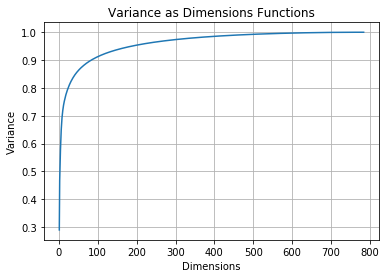

In [14]:
pca = PCA(random_state=0)
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
x = np.arange(1, len(cumsum)+1)
plt.plot(x, cumsum)
plt.grid(True)
plt.title('Variance as Dimensions Functions')
plt.xlabel('Dimensions')
plt.ylabel('Variance')
plt.show()

In [15]:
pca = PCA(random_state=0, n_components=0.90)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
d = len(pca.singular_values_)
print('the number of vectors after pca is {}'.format(d))

the number of vectors after pca is 84


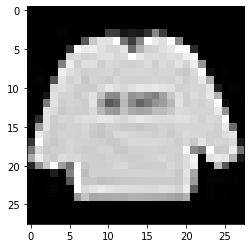

In [64]:
first_image = X_train[0]

first_image = np.array(first_image, dtype='uint8')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

---
# Models

## Run The Models

### Naive Bayes

Accuracy: 0.77 (+/- 0.01)
Train time: 0.08 seconds (+/- 0.01) for a total of 0.76 seconds
Test time: 0.08 seconds (+/- 0.01) for a total of 0.82 seconds
confusion_matrix:
 [[4562    1  122  401   21   32  443    0  416    2]
 [  32 5455  101  251   11    9   72    0   69    0]
 [  94    0 3820   38  768   41  905    0  333    1]
 [ 387   43   60 4840  192   27  308    0  143    0]
 [  36    3  638  299 3964   11  871    1  177    0]
 [  15    0    0    2    1 4656  122  892  217   95]
 [1021    2  679  213  474   29 3080    1  501    0]
 [   3    0    0    0    0  323   17 5262   18  377]
 [  60    0   41   50   52  127  223  165 5275    7]
 [   4    0    0    0    0  110   30  415   74 5367]]
              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75      6000
         1.0       0.99      0.91      0.95      6000
         2.0       0.70      0.64      0.67      6000
         3.0       0.79      0.81      0.80      6000
         4.0       0.72   

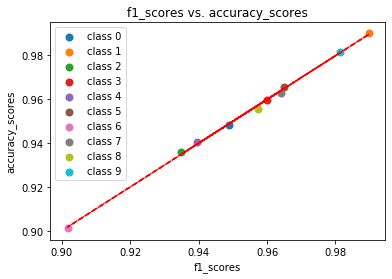

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9485, 1: 0.9901, 2: 0.9363166666666667, 3: 0.9597666666666667, 4: 0.94075, 5: 0.9657833333333333, 6: 0.9014833333333333, 7: 0.9631333333333333, 8: 0.95545, 9: 0.9814166666666667}
{0: 0.948900038149995, 1: 0.9899092079870554, 2: 0.9349773075173896, 3: 0.9599054982322028, 4: 0.9395573316545519, 5: 0.9649274370593732, 6: 0.9017406601351745, 7: 0.9640720945119391, 8: 0.9572550898242034, 9: 0.981311229521987}


In [17]:
gnb = GaussianNB()

# gnb.fit(X_train_pca, y_train)
# predictions = gnb.predict(X_test_pca)
# evaluate(y_test, predictions)

gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True)
score_models(gnb, gnb_scores)

pred = cross_val_predict(gnb, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES)
evaluate(y_train, pred, plot=True)

confusion_matrix:
 [[4573    1  125  397   21   33  436    0  412    2]
 [  30 5451  102  256   11    9   74    0   67    0]
 [  85    0 3836   40  752   42  917    0  327    1]
 [ 386   42   62 4841  189   28  313    0  139    0]
 [  36    3  628  301 3979   17  860    1  175    0]
 [  12    0    1    2    1 4650  128  906  206   94]
 [1016    2  671  212  472   31 3095    2  499    0]
 [   2    0    0    0    0  319   15 5272   16  376]
 [  63    0   41   51   54  128  219  166 5271    7]
 [   4    0    0    0    0  112   29  420   74 5361]]
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75      6000
         1.0       0.99      0.91      0.95      6000
         2.0       0.70      0.64      0.67      6000
         3.0       0.79      0.81      0.80      6000
         4.0       0.73      0.66      0.69      6000
         5.0       0.87      0.78      0.82      6000
         6.0       0.51      0.52      0.51      6000
         7.0     

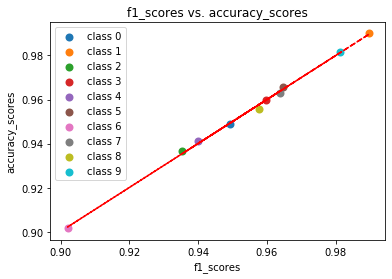

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9489833333333333, 1: 0.99005, 2: 0.9367666666666666, 3: 0.9597, 4: 0.9413166666666667, 5: 0.9655166666666667, 6: 0.9017333333333334, 7: 0.96295, 8: 0.9559333333333333, 9: 0.98135}
{0: 0.9493669056128093, 1: 0.9898562161032405, 2: 0.9354497579496196, 3: 0.9598478542268246, 4: 0.9401257965482228, 5: 0.9646598739704587, 6: 0.9020437940986289, 7: 0.9639304191654111, 8: 0.9576704516110539, 9: 0.9812384929371392}


In [18]:
cv_mean_model(gnb_scores['estimator'], y_train, X_train_pca)

In [19]:
# predictions = np.array([])
# size = len(y_train)
# split = size//CV_SPLIT
# X_cv_split = np.arange(0, size+1, split)

# for idx, estimator in enumerate(gnb_scores['estimator']):

#     predictions = np.append(predictions, estimator.predict(X_train_pca[X_cv_split[idx]:X_cv_split[idx+1]]))
    
# #     predictions = estimator.predict(X_train_pca)
# #     evaluate(y_train, predictions, plot=True)
    
# #     print(predictions)

# evaluate(y_train, predictions, plot=True)

In [20]:
# size = len(y_train)
# split = size//CV_SPLIT
# X_cv_split = np.arange(0, size+1, split)

# pred_2d = np.zeros((CV_SPLIT ,60000))
# # pred_2d = np.append(pred_2d, [])
# for idx, estimator in enumerate(gnb_scores['estimator']):
#     print(idx)
#     pred = estimator.predict(X_train_pca)
#     pred_2d[idx] = pred
# pred_2d

In [21]:
# # np.average(pred_2d[:0])
# predictions = pred_2d[0].copy()
# for idx in range(CV_SPLIT):
#     predictions[idx] = int(np.round(np.average(pred_2d[:][idx])))
# # pred_2d[:][0]

In [22]:
# if np.all(predictions != pred_2d[1]):
#     print("very difrent")
# elif np.any(predictions != pred_2d[1]):
#     print("a bit difrent")

In [23]:
# evaluate(y_train, predictions, plot=True)

In [24]:
# mnb = MultinomialNB()
# mnb.fit(X_train_pca, y_train)
# predictions = mnb.predict(X_test_pca)
# evaluate(y_test, predictions)

### Random Forest

Accuracy: 0.87 (+/- 0.01)
Train time: 33.19 seconds (+/- 4.25) for a total of 331.91 seconds
Test time: 0.17 seconds (+/- 0.10) for a total of 1.66 seconds
confusion_matrix:
 [[5927    0   11   15    2    2   39    0    4    0]
 [   2 5973    5   14    0    0    5    0    1    0]
 [   7    0 5877    6   64    2   41    0    3    0]
 [  23    2    2 5934   16    0   20    0    3    0]
 [   1    1   28   22 5906    0   29    0   13    0]
 [   0    0    0    0    1 5955    0   24    5   15]
 [ 108    1   78   18   57    2 5730    0    6    0]
 [   0    0    0    0    0   24    0 5950    0   26]
 [   2    0    4    3    5    5    8    3 5970    0]
 [   0    0    0    0    1   12    0   21    0 5966]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      6000
         1.0       1.00      1.00      1.00      6000
         2.0       0.98      0.98      0.98      6000
         3.0       0.99      0.99      0.99      6000
         4.0       0.98

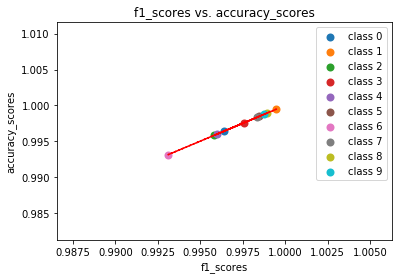

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9964, 1: 0.9994833333333333, 2: 0.9958166666666667, 3: 0.9976, 4: 0.996, 5: 0.9984666666666666, 6: 0.9931333333333333, 7: 0.9983666666666666, 8: 0.9989166666666667, 9: 0.99875}
{0: 0.9964092716818898, 1: 0.9994828922473242, 2: 0.995817440990556, 3: 0.9976010654530489, 4: 0.9960076658463144, 5: 0.9984667802253578, 6: 0.993100380581186, 7: 0.9983665456560432, 8: 0.9989168671887895, 9: 0.9987503238588987}


In [25]:
rf = RandomForestClassifier(random_state=0, max_depth=None, n_estimators=100, n_jobs=CORES)

# scores = cross_val_score(rf, X_train_pca, y_train, cv=10, scoring='neg_mean_squared_error')
# rf_score = np.sqrt(-scores)
rf_scores = cross_validate(rf, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(rf, rf_scores)
cv_mean_model(rf_scores['estimator'], y_train, X_train_pca)

### KNN

#### find the optimum K 

In [31]:
k_max = 15
k_min = 1
err_rate = []
for i in range(k_min, k_max+1):
    k = KNeighborsClassifier(n_neighbors=i, n_jobs=CORES)
#     k.fit(X_train_pca, y_train)
#     pred_i = k.predict(X_test_pca)
#     err_rate.append(np.mean(pred_i != y_test))
    scores = cross_validate(k, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)['test_score']
    if scores.std() > 0.5:
        err_rate.append(0)
    else:
        err_rate.append(scores.mean())

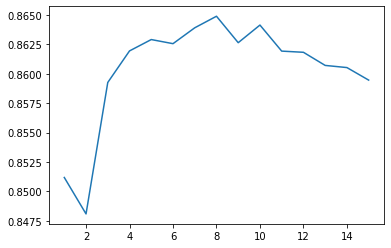

In [32]:
plt.plot(np.arange(k_min, k_max+1), err_rate)
plt.show()

In [33]:
index = err_rate.index(max(err_rate)) + 1
index

8

Accuracy: 0.86 (+/- 0.01)
Train time: 1.94 seconds (+/- 0.16) for a total of 19.37 seconds
Test time: 17.54 seconds (+/- 7.61) for a total of 175.36 seconds
confusion_matrix:
 [[5433    2   67  103   30    1  315    1   46    2]
 [  23 5832   18   92    8    0   22    0    4    1]
 [  75    3 5019   43  510    1  335    1   13    0]
 [ 195   26   44 5454  165    0  102    0   13    1]
 [  22    6  483  189 4926    0  356    0   18    0]
 [   3    0    0    1    1 5506    5  264   15  205]
 [ 999    6  642  104  450    0 3745    0   53    1]
 [   0    0    0    0    0   58    0 5754    1  187]
 [  21    1   35   34   34    9   40   23 5798    5]
 [   0    0    1    0    1   29    1  213    2 5753]]
              precision    recall  f1-score   support

         0.0       0.80      0.91      0.85      6000
         1.0       0.99      0.97      0.98      6000
         2.0       0.80      0.84      0.82      6000
         3.0       0.91      0.91      0.91      6000
         4.0       0.8

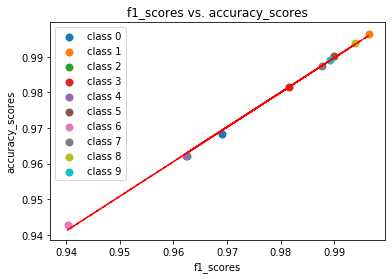

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.96825, 1: 0.9964666666666666, 2: 0.96215, 3: 0.9814666666666667, 4: 0.9621166666666666, 5: 0.9901333333333333, 6: 0.9428166666666666, 7: 0.9875333333333334, 8: 0.9938833333333333, 9: 0.9891833333333333}
{0: 0.9690942473324972, 1: 0.9964502465695644, 2: 0.9625707834119135, 3: 0.9814803690459716, 4: 0.9622899929519417, 5: 0.9899830003992027, 6: 0.9402746226710922, 7: 0.9876487230925873, 8: 0.9938749217104037, 9: 0.9892445270350925}


In [34]:
k = KNeighborsClassifier(n_neighbors=index, n_jobs=CORES)
k_scores = cross_validate(k, X_train_pca, y_train, cv=CV_SPLIT, n_jobs=CORES, return_estimator=True)
score_models(k, k_scores)

cv_mean_model(k_scores['estimator'], y_train, X_train_pca)

### Logistic Regression

Accuracy: 0.84 (+/- 0.01)
Train time: 15.97 seconds (+/- 4.17) for a total of 159.75 seconds
Test time: 0.01 seconds (+/- 0.01) for a total of 0.11 seconds
confusion_matrix:
 [[4979   22  105  298   35   17  479    9   53    3]
 [  23 5772   27  134   16    0   24    2    2    0]
 [  81   23 4412   65  799   14  548    5   53    0]
 [ 215   69   62 5215  209    3  195    4   23    5]
 [  11   13  543  234 4569    4  592    1   33    0]
 [   6    0    1    2    1 5567    2  286   39   96]
 [ 911   15  677  203  638   12 3419    7  115    3]
 [   0    0    0    0    0  240    1 5520   14  225]
 [  25    7   37   58   21   49  124   38 5624   17]
 [   0    0    0    1    1   92    1  218    4 5683]]
              precision    recall  f1-score   support

         0.0       0.80      0.83      0.81      6000
         1.0       0.97      0.96      0.97      6000
         2.0       0.75      0.74      0.74      6000
         3.0       0.84      0.87      0.85      6000
         4.0       0.73

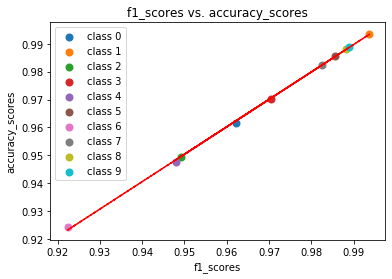

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9617833333333333, 1: 0.9937166666666667, 2: 0.9493333333333334, 3: 0.9703333333333334, 4: 0.9474833333333333, 5: 0.9856, 6: 0.9242166666666667, 7: 0.9825, 8: 0.9881333333333333, 9: 0.9889}
{0: 0.962130314592234, 1: 0.9936981433559601, 2: 0.9490747921088956, 3: 0.970559553303778, 4: 0.948030395791548, 5: 0.985598933130831, 6: 0.9223843679889266, 7: 0.9825578387283034, 8: 0.9881156861264067, 9: 0.9889131157064662}


In [35]:
lr = LogisticRegression(random_state=0, n_jobs=CORES)#, solver='lbfgs', penalty='l2')
lr_scores = cross_validate(lr, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(lr, lr_scores)

cv_mean_model(lr_scores['estimator'], y_train, X_train_pca)

### SVM

#### SVC

Accuracy: 0.79 (+/- 0.02)
Train time: 100.06 seconds (+/- 27.85) for a total of 1000.64 seconds
Test time: 14.48 seconds (+/- 4.82) for a total of 144.85 seconds
confusion_matrix:
 [[4245    4   90  294    9    4 1326    0   27    1]
 [  21 5829   15  116    2    0   15    0    2    0]
 [  76    2 3057   52  254    2 2542    0   15    0]
 [  88   24  108 5514   75    1  176    0   14    0]
 [  20    6  754  578 1265    3 3360    0   14    0]
 [   2    0    0    1    0 5502    1  441   14   39]
 [ 956    8  503  186  161    2 4140    0   44    0]
 [   0    0    0    0    0   37    0 5573    7  383]
 [  15    2   27   22   15    9   34   13 5862    1]
 [   1    0    0    2    0   75    0   85    2 5835]]
              precision    recall  f1-score   support

         0.0       0.78      0.71      0.74      6000
         1.0       0.99      0.97      0.98      6000
         2.0       0.67      0.51      0.58      6000
         3.0       0.82      0.92      0.86      6000
         4.0     

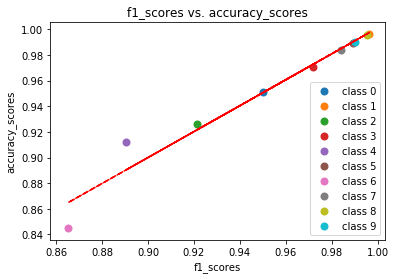

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9511, 1: 0.9963833333333333, 2: 0.926, 3: 0.97105, 4: 0.9124833333333333, 5: 0.9894833333333334, 6: 0.8447666666666667, 7: 0.9839, 8: 0.9953833333333333, 9: 0.9901833333333333}
{0: 0.949996935113568, 1: 0.9963663888043809, 2: 0.921419486223848, 3: 0.9718142167418746, 4: 0.8904019114981693, 5: 0.9893360862359541, 6: 0.8652049663941983, 7: 0.9839660817588415, 8: 0.9953835043047611, 9: 0.9902752341293127}


In [36]:
svc = SVC(random_state=0, max_iter=500)

svc_scores = cross_validate(svc, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(svc, svc_scores)
cv_mean_model(svc_scores['estimator'], y_train, X_train_pca)

### Decision Tree

Accuracy: 0.77 (+/- 0.01)
Train time: 13.20 seconds (+/- 0.68) for a total of 131.95 seconds
Test time: 0.00 seconds (+/- 0.00) for a total of 0.03 seconds
confusion_matrix:
 [[5848    9   13   26    7    2   88    0    7    0]
 [   7 5954    6   22    2    0    7    0    2    0]
 [  12    2 5795    6   89    2   83    0    9    2]
 [  33   17    9 5860   41    1   34    0    5    0]
 [  11    1   83   19 5797    4   77    0    7    1]
 [   5    0    1    2    1 5913    1   49    5   23]
 [  99    5   70   41   75    1 5696    0   13    0]
 [   0    0    0    0    0   52    0 5907    5   36]
 [  13    2    8    7    6    6   23    2 5931    2]
 [   3    0    0    1    0   23    1   39    4 5929]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      6000
         1.0       0.99      0.99      0.99      6000
         2.0       0.97      0.97      0.97      6000
         3.0       0.98      0.98      0.98      6000
         4.0       0.96

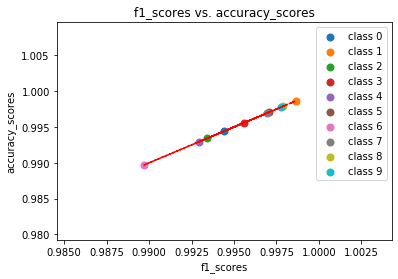

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9944166666666666, 1: 0.9986333333333334, 2: 0.9934166666666666, 3: 0.9956, 4: 0.9929333333333333, 5: 0.9970333333333333, 6: 0.9897, 7: 0.99695, 8: 0.9979, 9: 0.99775}
{0: 0.9944230583479285, 1: 0.998632826679703, 2: 0.9934130040461051, 3: 0.9955973886279815, 4: 0.9929380364081871, 5: 0.9970337726727114, 6: 0.9897038111972467, 7: 0.9969496610145981, 8: 0.9978990656026542, 9: 0.997749416278905}


In [37]:
dtc = DecisionTreeClassifier(random_state=0)
dtc_scores = cross_validate(dtc, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(dtc, dtc_scores)
cv_mean_model(dtc_scores['estimator'], y_train, X_train_pca)

### Gradient Boosting

In [ ]:
gb = GradientBoostingClassifier(random_state=0)
gb_scores = cross_validate(gb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
score_models(gb, gb_scores)
cv_mean_model(gb_scores['estimator'], y_train, X_train_pca)

### K Means

confusion_matrix:
 [[   0 3416   41  177 1702    2  444  173   21   24]
 [   0  243   44 5382  173    0  130   26    2    0]
 [   0   86 1843   10 1765    1  400 1853   20   22]
 [   1 1683   58 3118  682    0  422   20    5   11]
 [   0  690 3065  151  949    0  193  912   12   28]
 [ 484    1    0    1   41 1410 4038    0   10   15]
 [   1 1048 1219   51 2089    6  591  932   44   19]
 [ 290    0    0    0    0 5095  608    0    7    0]
 [   5   23   43   24  335  274  411  280 2161 2444]
 [5052    8    8    2   55  672  193    3    5    2]]
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6000
         1.0       0.03      0.04      0.04      6000
         2.0       0.29      0.31      0.30      6000
         3.0       0.35      0.52      0.42      6000
         4.0       0.12      0.16      0.14      6000
         5.0       0.19      0.23      0.21      6000
         6.0       0.08      0.10      0.09      6000
         7.0     

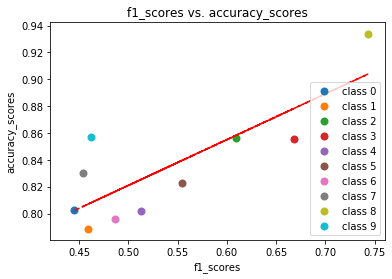

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.8027833333333333, 1: 0.7881333333333334, 2: 0.8560833333333333, 3: 0.8553333333333333, 4: 0.8017833333333333, 5: 0.8226666666666667, 6: 0.7958666666666666, 7: 0.8300166666666666, 8: 0.9339166666666666, 9: 0.8573166666666666}
{0: 0.445302171641998, 1: 0.45889988643055507, 2: 0.6094859882950762, 3: 0.6677369823101026, 4: 0.512824330120704, 5: 0.5548205321456674, 6: 0.48654137953995114, 7: 0.4535568892815184, 8: 0.7430235126108284, 9: 0.46182098098229296}


In [59]:
from sklearn.cluster import KMeans
# k = 5
km = KMeans(n_clusters=10, n_jobs=CORES) #(n_clusters=k)
pred = km.fit_predict(X_train_pca)
# evaluate(y_train, pred, plot=True)
evaluate(y_train, pred, plot=True)

In [65]:
# plt.scatter(X_train, [y_train])

## Find Best Model

In [39]:
best_model, best_model_score = find_best_model()

the best model is RandomForestClassifier with the score of 0.8675


## Improve The Model

### Ada Boost

confusion_matrix:
 [[5929    1   11   15    2    1   37    0    4    0]
 [   2 5971    6   16    0    0    4    0    1    0]
 [   5    0 5887    6   58    3   37    0    4    0]
 [  18    1    5 5939   19    0   15    0    3    0]
 [   1    1   32   23 5907    0   29    0    7    0]
 [   0    0    0    0    1 5949    0   27    6   17]
 [ 113    1   74   18   48    0 5739    0    7    0]
 [   0    0    0    0    0   22    0 5957    0   21]
 [   3    0    3    3    3    2    6    3 5976    1]
 [   0    0    1    0    1    8    0   21    0 5969]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      6000
         1.0       1.00      1.00      1.00      6000
         2.0       0.98      0.98      0.98      6000
         3.0       0.99      0.99      0.99      6000
         4.0       0.98      0.98      0.98      6000
         5.0       0.99      0.99      0.99      6000
         6.0       0.98      0.96      0.97      6000
         7.0     

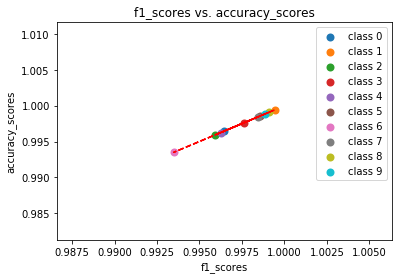

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.99645, 1: 0.99945, 2: 0.9959166666666667, 3: 0.9976333333333334, 4: 0.99625, 5: 0.99855, 6: 0.9935166666666667, 7: 0.9984333333333333, 8: 0.9990666666666667, 9: 0.9988333333333334}
{0: 0.99645927264571, 1: 0.9994494895299404, 2: 0.9959195349500025, 3: 0.9976350830975972, 4: 0.9962553966815454, 5: 0.9985491932962309, 6: 0.9934843226666601, 7: 0.9984337971786496, 8: 0.9990669430000465, 9: 0.9988336787500581}


In [40]:
base_estimetor = best_model
adb = AdaBoostClassifier(base_estimetor, random_state=0)
adb_scores = cross_validate(adb, X_train_pca, y_train, cv=CV_SPLIT, return_estimator=True, n_jobs=CORES)
cv_mean_model(adb_scores['estimator'], y_train, X_train_pca)

#### check if the model was improved

In [41]:
if adb_scores['test_score'].mean() > best_model_score:
    print('ada boost helped')
    best_model = adb

ada boost helped


## Test The Model On The Test Data

confusion_matrix:
 [[918   0  23  19   3   3  25   1   8   0]
 [ 11 966   7  16   0   0   0   0   0   0]
 [ 23   0 868   8  74   1  21   0   5   0]
 [ 50   9  19 903  12   0   7   0   0   0]
 [  4   1 135  39 795   0  23   0   3   0]
 [  1   0   0   1   0 940   0  40   4  14]
 [268   1 164  26  82   2 447   0  10   0]
 [  0   0   0   0   0  55   0 901   0  44]
 [  6   0  15   4   5  16   5   5 943   1]
 [  0   0   0   0   0  30   1  47   0 922]]
              precision    recall  f1-score   support

         0.0       0.72      0.92      0.80      1000
         1.0       0.99      0.97      0.98      1000
         2.0       0.71      0.87      0.78      1000
         3.0       0.89      0.90      0.90      1000
         4.0       0.82      0.80      0.81      1000
         5.0       0.90      0.94      0.92      1000
         6.0       0.84      0.45      0.58      1000
         7.0       0.91      0.90      0.90      1000
         8.0       0.97      0.94      0.96      1000
         

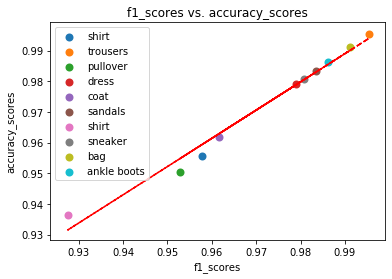

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9555, 1: 0.9955, 2: 0.9505, 3: 0.979, 4: 0.9619, 5: 0.9833, 6: 0.9365, 7: 0.9808, 8: 0.9913, 9: 0.9863}
{0: 0.9578881570220914, 1: 0.9954766953067977, 2: 0.9527408858930908, 3: 0.9790739916963228, 4: 0.9616503531052162, 5: 0.983469859733352, 6: 0.9275291949174281, 7: 0.9807743122737089, 8: 0.9912469865905652, 9: 0.9862415237895028}


In [118]:
cv_mean_model(adb_scores['estimator'], y_test, X_test_pca)

confusion_matrix:
 [[857   0  19  36   3   3  70   0  12   0]
 [  4 963   8  19   2   0   4   0   0   0]
 [ 12   0 802   7 105   1  61   0  12   0]
 [ 26   6  11 909  24   1  19   0   4   0]
 [  1   1  66  26 850   0  50   0   6   0]
 [  1   0   0   1   0 917   0  52   5  24]
 [178   2 104  26  83   1 591   0  15   0]
 [  0   0   0   0   0  39   0 903   0  58]
 [  2   0   6   4   3  10   5   4 965   1]
 [  0   0   0   0   0  16   0  39   0 945]]
              precision    recall  f1-score   support

         0.0       0.79      0.86      0.82      1000
         1.0       0.99      0.96      0.98      1000
         2.0       0.79      0.80      0.80      1000
         3.0       0.88      0.91      0.90      1000
         4.0       0.79      0.85      0.82      1000
         5.0       0.93      0.92      0.92      1000
         6.0       0.74      0.59      0.66      1000
         7.0       0.90      0.90      0.90      1000
         8.0       0.95      0.96      0.96      1000
         

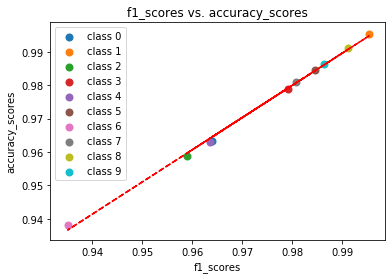

[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
{0: 0.9633, 1: 0.9954, 2: 0.9588, 3: 0.979, 4: 0.963, 5: 0.9846, 6: 0.9382, 7: 0.9808, 8: 0.9911, 9: 0.9862}
{0: 0.9639312996905103, 1: 0.9953709150201783, 2: 0.9589451646613568, 3: 0.9791286116338762, 4: 0.9635533785440428, 5: 0.9845586510401517, 6: 0.935106227106227, 7: 0.9807914569385517, 8: 0.9911371749812738, 9: 0.9862845162165471}


In [43]:
best_model.fit(X_train_pca, y_train)
predictions = best_model.predict(X_test_pca)
evaluate(y_test, predictions, plot=True)

### run without pca

In [44]:
# best_model.fit(X_train, y_train)
# predictions = best_model.predict(X_test)
# evaluate(y_test, predictions)

In [45]:
# from sklearn.preprocessing import label_binarize

# labels = [0, 1, 2, 3,4,5,6,7,8,9]
# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# roc_auc_score(ytest, ypreds, average='macro',multi_class='ovo')
# # plot_roc_curve(best_model, X_test_pca, y_test)

In [46]:
# # precision recall curve
# # precision = dict()
# # recall = dict()
# # for i in range(n_classes):
# #     precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
# #                                                         y_score[:, i]))
# #     plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))
# n_classes = len(labels)
# roc_scores = [0, 1, 2, 3,4,5,6,7,8,9]
# for i in range(n_classes):
#     roc_scores[i] = roc_auc_score(ytest[:, i], ypreds[:, i], average='macro',multi_class='ovo')
#     plt.scatter(labels[i], roc_scores[i], lw=2, label='class {}'.format(i))

# # plt.plot(labels, roc_scores, lw=2, label='class {}'.format(i))
# plt.xlabel("recall")
# plt.ylabel("precision")
# plt.legend(loc="best")
# plt.title("precision vs. recall curve")
# plt.show()

# for i in range(n_classes):
#     print('{} {}'.format(labels[i], roc_scores[i]))

In [47]:
# gnb = GaussianNB()
# # 
# # gnb.fit(X_train_pca, y_train)
# # predictions = gnb.predict(X_test_pca)
# # evaluate(y_test, predictions)

# gnb_scores = cross_validate(gnb, X_train_pca, y_train, cv=10)
# score_models('GaussianNB', gnb_scores)

# pred = cross_val_predict(gnb, X_train_pca, y_train, cv=10, n_jobs=CORES)

# print(accuracy_score(y_train, pred))

# evaluate(y_train, pred, plot=True)
# # print(f1_score(y_train, pred, average='macro'))

# # tmp = plot_scores(y_train, pred)
# # tmp

In [48]:
# evaluate(y_test, predictions)

# ytest = label_binarize(y_test, classes=labels)
# ypreds = label_binarize(predictions, classes=labels)

# # scoring = 'average_precision'
# fpr, tpr, thresholds = roc_curve(ytest, ypreds)
# scores = []
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(average_precision_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 


# scores = []
# thresholds = np.arange(0, 1, 0.01)
# for x in thresholds:
#     predictions_class = binarize([predictions], x)[0]
#     scores.append(accuracy_score(y_test, predictions_class))
# scores = np.array(scores)
# index = np.argmax(scores) 
# predictions_class = binarize([predictions], thresholds[index])[0]
# evaluate(y_test, predictions_class)


# thresholds[index]
# predictions
# # binarize([predictions], 0.5)[0]
# y_test

In [49]:
# ### Predict test_y values and probabilities based on fitted logistic 
# # regression model

# pred_y=best_model.predict(X_test_pca) 
# # pred_y = predictions

# probs_y=best_model.predict_proba(X_test_pca) 
# #   # probs_y is a 2-D array of probability of being labeled as 0 (first 
# #   column of 
# #   array) vs 1 (2nd column in array)

# from sklearn.metrics import precision_recall_curve
# precision, recall, thresholds = precision_recall_curve(y_test, probs_y[:, 
# 1]) 
#    #retrieve probability of being 1(in second column of probs_y)
# pr_auc = metrics.auc(recall, precision)

# plt.title("Precision-Recall vs Threshold Chart")
# plt.plot(thresholds, precision[: -1], "b--", label="Precision")
# plt.plot(thresholds, recall[: -1], "r--", label="Recall")
# plt.ylabel("Precision, Recall")
# plt.xlabel("Threshold")
# plt.legend(loc="lower left")
# plt.ylim([0,1])